In [7]:
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use("huntstone")
import numpy as np
from multiprocessing import Pool
from functools import partial
from scipy.constants import c
import sys
sys.path.insert(0, "../../python/")
import eo_signal as eos
from plotting import makefig
import time
#npeaks = np.load("/home/keenan/eos_bpm/khuntstone/current_profiles/npeaks.npy")
#p2ps   = np.load("/home/keenan/eos_bpm/khuntstone/current_profiles/Idz.npy")

In [8]:
def get_sep(ind, d, angle):
    I, ti, Idz, sig, t_sig, gamma, t_gamma \
                   = eos.get_signal(ind, "GaP", d, 800e-9, 30e-15, angle, 1e-3, "cross")
    Sdz = eos.peak2peak(sig, t_sig)
    error_z = abs(Sdz - Idz)
    error_p = error_z/ Idz
    #if npeaks[ind] > 2:
    #    error = np.nan
    return error_z, error_p

def plot_result(errors, omits):
    err_plot = np.flipud(np.transpose(errors))
    fig1, ax1 = makefig(xlab = r'd [$\mu$m]', ylab = "Angle [deg.]")
    ext       = [25, 200, 10, 60]
    img1      = ax1.imshow(err_plot*100, cmap = 'CMRmap', extent = ext, aspect = 'auto')
    cbar      = plt.colorbar(mappable = img1, label = 'Avg. Error [%]')
    
    om_plot   = np.flipud(np.transpose(omits))
    fig2, ax2 = makefig(xlab = r'd [$\mu$m]', ylab = "Angle [deg.]")
    img2      = ax2.imshow(om_plot, cmap = "CMRmap", extent = ext, aspect = 'auto')
    cbar      = plt.colorbar(mappable = img2, label = 'Failure Rate [%]') 

In [12]:
# Comparing d = 50, 75, and 100 microns
if False:
    ds     = np.array([50, 75, 100])
    N      = 3135
    inds   = np.arange(0, N, 1)
    err50  = partial(get_sep, d = 50e-6, angle = 15)
    err75  = partial(get_sep, d = 75e-6, angle = 15)
    err100 = partial(get_sep, d = 100e-6, angle = 15)

    # 50
    p = Pool(4)
    e50z, e50p = zip(*p.map(err50, inds))
    p.close()
    p.join()
    # 75
    p = Pool(4)
    e75z, e75p = zip(*p.map(err75, inds))
    p.close()
    p.join()
    # 100
    p = Pool(4)
    e100z, e100p = zip(*p.map(err100, inds))
    p.close()
    p.join()

In [13]:
# Convert to microns
e50z = np.array(e50z) * c * 1e6
e75z = np.array(e75z) * c * 1e6
e100z = np.array(e100z) * c * 1e6

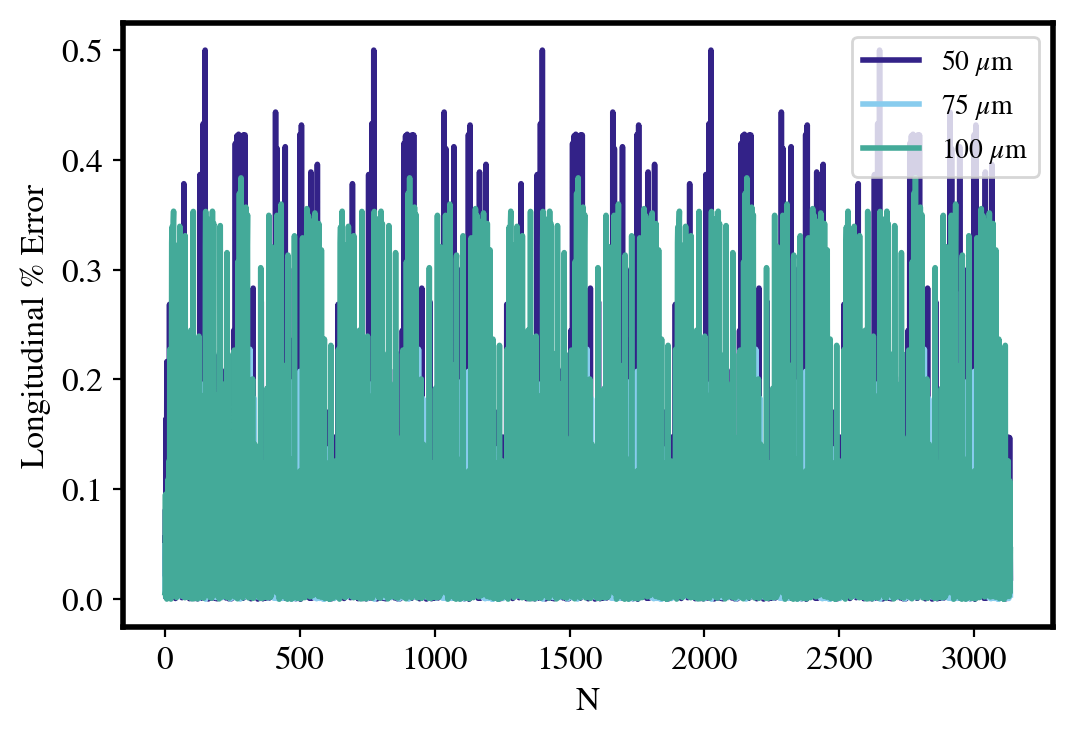

In [15]:
fig, ax = makefig()
ax.set_xlabel("N")
ax.set_ylabel("Longitudinal % Error")
ax.plot(e50p, label = r'50 $\mu$m')
ax.plot(e75p, label = r'75 $\mu$m')
ax.plot(e100p, label = r'100 $\mu$m')
ax.legend()
plt.show()

In [3]:
ds     = np.array([25, 50, 100, 150, 200])*1e-6
ths    = np.arange(10, 61, 5)
N      = 10
inds   = np.arange(0, N, 1)
errors = np.zeros((len(ds), len(ths)))
omits = np.zeros((len(ds), len(ths)))
start  = time.time()
par    = True
for i in range(len(ds)):
    print(i+1, "of", len(ds))
    for j in range(len(ths)):
        if par == False:
            err= np.zeros(len(inds))
            for k in range(len(inds)):
                err[k] = get_sep(inds[k], ds[i], ths[j])
            errors[i,j] = np.nanmean(err)
            omits[i,j]  = np.sum(np.isnan(err))
        elif par == True:
            pool  = Pool(4)
            errf  = partial(get_sep, d = ds[i], angle = ths[j])
            err = pool.map(errf, inds)
            pool.close()
            pool.join()
            errors[i,j] = np.nanmean(err)
            omits[i,j]  = np.sum(np.isnan(err))         
print(time.time() - start)
if par == False:
    l_omits = omits
    l_errors = errors

1 of 5
2 of 5
3 of 5
4 of 5
5 of 5
15.706625938415527


In [3]:
err = np.load("2peakerr.npy")

In [9]:
err[2, 7]*150.426314715368

4.432043350145474

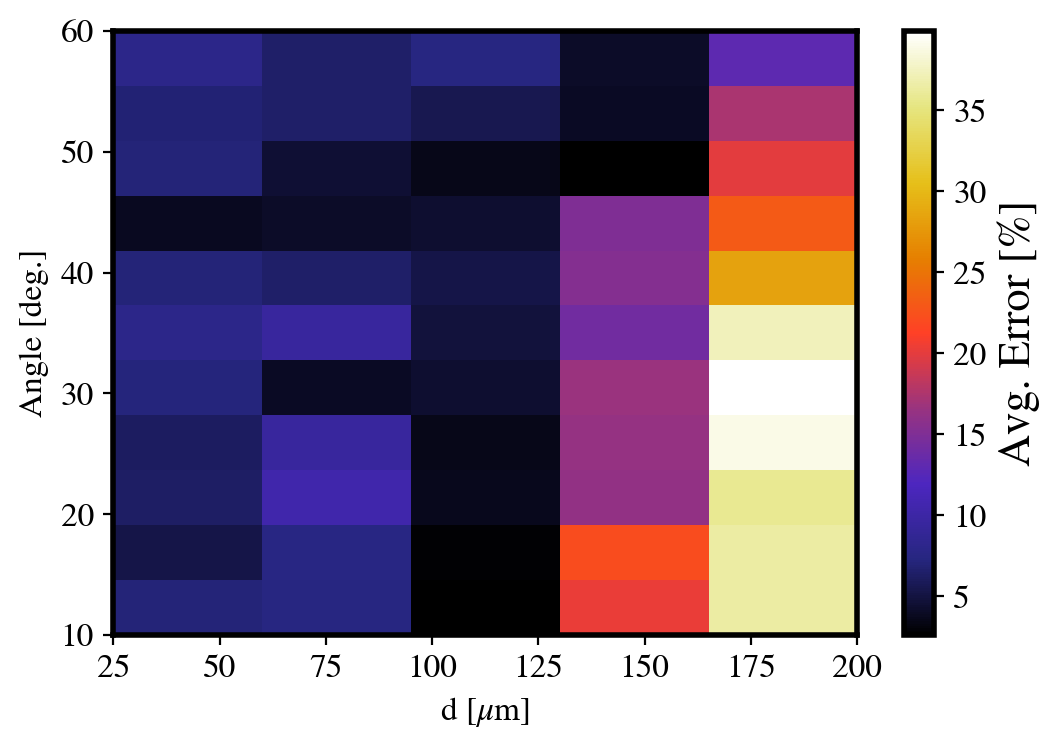

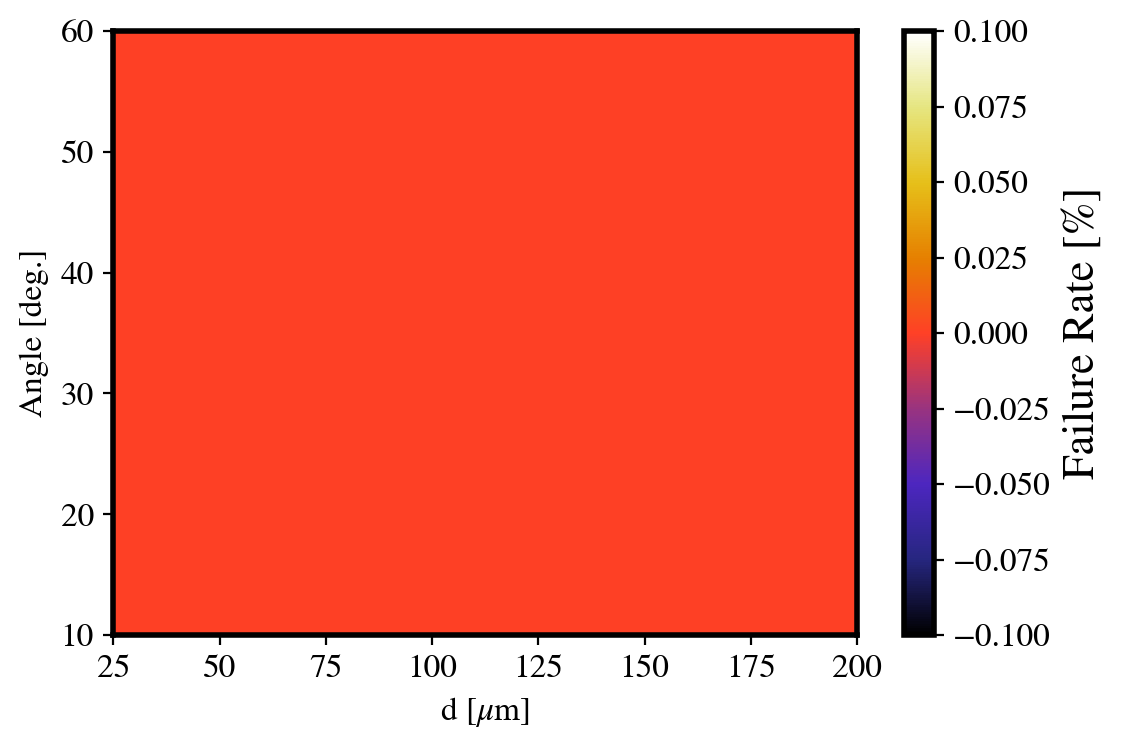

In [5]:
plot_result(errors, omits)

In [3]:
def get_peak(ind, r):
    I, ti, Idz, sig, t_sig, gamma, t_gamma \
                   = eos.get_signal(ind, "GaP", 100e-6, 800e-9, 30e-15, 15, r, "cross")
    return np.nanmax(sig)

In [5]:
# Parameter scan of offset from beam axis
d     = 100e-6
th    = 15
r0    = np.arange(1, 5.1, 0.5)*1e-3
dx    = np.linspace(-100, 100, 100)*1e-6
peak  = np.zeros([len(r0), len(dx)])
N     = 3134
inds  = np.arange(0, N, 1)
start = time.time()
for i in range(len(r0)):
    print(i+1, "of", len(r0))
    for j in range(len(dx)):
        smax = partial(get_peak, r = r0[i] + dx[j])
        pool  = Pool(4)
        peaks = pool.map(smax, inds)
        pool.close()
        pool.join()
        peak[i,j] = np.nanmean(peaks)
print(time.time()-start)

1 of 9
2 of 9
3 of 9
4 of 9
5 of 9
6 of 9
7 of 9
8 of 9
9 of 9
116413.7754600048


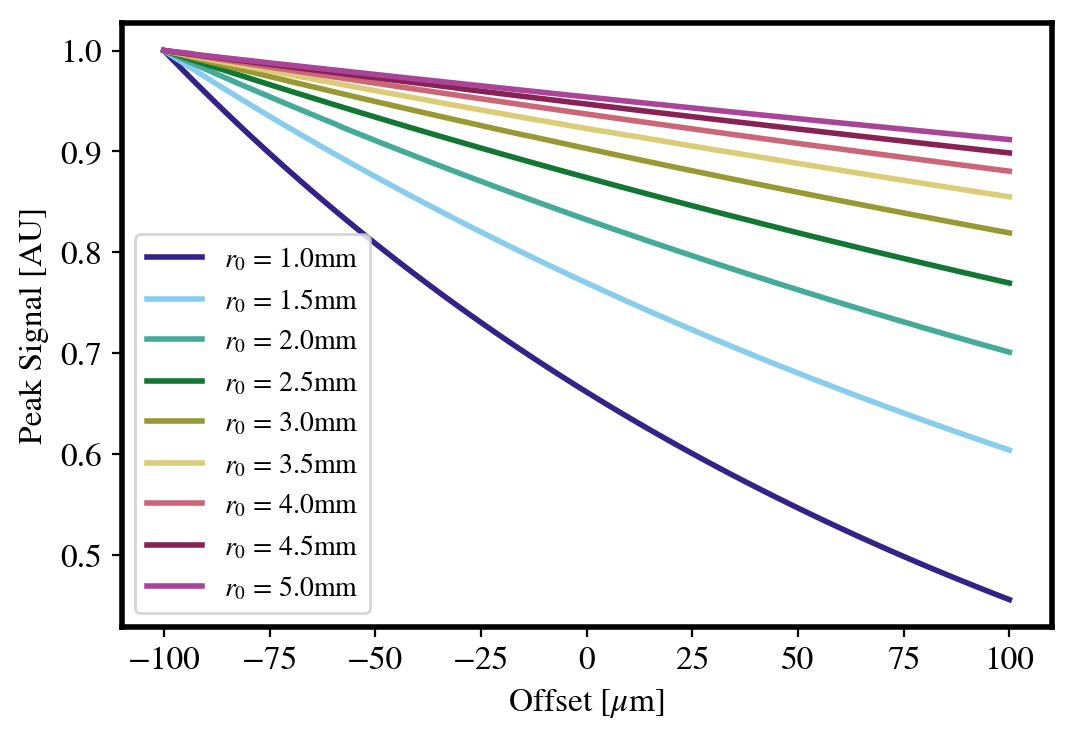

In [7]:
fig, ax = makefig(xlab = r'Offset [$\mu$m]', ylab = 'Peak Signal [AU]')
for i in range(len(r0)):
    lab = r'$r_0$ = ' + str(np.round(r0[i]*1e3,2)) + "mm"
    ax.plot(dx*1e6, peak[i,:] / max(peak[i,:]), label = lab)
ax.legend()
plt.show()